In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [74]:
df = pd.read_csv("../data/profiles.csv")

## Remove unneeded variables

First, let's drop all the columns we won't use.

In [75]:
df.drop(['last_online', 'location', 'sign', 'speaks', "ethnicity"], axis=1, inplace=True)
df.drop([f"essay{n}" for n in np.arange(0,10)], axis=1, inplace=True)

## Refactor "diet" variable

The "diet" variable has 6 possible cuisines (anything, vegetarian, vegan, kosher, halal, and other) and 2 changers (mostly/strictly), which might create unnecessary dummy variables that won't add value to the model. So let's boil it down to diet type without the nuance.

In [76]:
df.dropna(axis=0, subset=['diet'], inplace=True)
df['vegetarian'] = df['diet'].apply(lambda x: 1 if ("vegetarian" in x) or ("vegan" in x) else 0)
df.drop("diet", axis=1, inplace=True)

## Convert "drink" values into a numerical scale

In [77]:
df["heavy_drinker"] = df['drinks'].apply(lambda x: 1 if (x=="very often") or (x=="desperately") else 0)
df.drop("drinks", axis=1, inplace=True)

In [78]:
df["drug_user"] = df['drugs'].apply(lambda x: 1 if (x=="often") else 0)
df.drop("drugs", axis=1, inplace=True)

## Extract offspring

In [79]:
df.dropna(axis=0, subset=["offspring"], inplace=True)
df['offspring'].replace(['doesn&rsquo;t have kids',
                         'doesn&rsquo;t have kids, and doesn&rsquo;t want any',
                         'doesn&rsquo;t have kids, but might want them',
                         'doesn&rsquo;t have kids, but wants them',
                         'might want kids',
                         'doesn&rsquo;t want kids',
                         'wants kids'], 0, inplace=True)

df['offspring'].replace(['has a kid',
                         'has a kid, and might want more',
                         'has a kid, and wants more',
                         'has a kid, but doesn&rsquo;t want more',
                         'has kids',
                         'has kids, and might want more',
                         'has kids, and wants more',
                         'has kids, but doesn&rsquo;t want more',], 1, inplace=True)

## Cleaning up religion

Let's remove the religion variable modifiers.

In [82]:
df.dropna(axis=0, subset=["religion"], inplace=True)
df['religion_serious'] = df['religion'].apply(lambda x: 1 if "very serious" in x else 0)
df['religion'].replace([" and laughing about it",
                       " and somewhat serious about it",
                       " and very serious about it",
                       " but not too serious about it"], "", regex=True, inplace=True)

In [83]:
df['religion']

0         agnosticism
1         agnosticism
5             atheism
7        christianity
8        christianity
             ...     
59936         atheism
59937         judaism
59942     agnosticism
59943    christianity
59944     agnosticism
Name: religion, Length: 25403, dtype: object

## Extract pet information

In [84]:
df["pets"].fillna("Unknown", inplace=True)
df['has_dogs'] = df['pets'].apply(lambda x: 1 if ("has dogs" in x) else 0)
df['has_cats'] = df['pets'].apply(lambda x: 1 if ("has cats" in x) else 0)
df['has_pets'] = df[['has_dogs', 'has_cats']].any(axis=1)
df.drop('pets', axis=1, inplace=True)

## Create dummy variables from categorical columns

In [85]:
def create_dummy(df):
    """
    Creates dummy variables for all the categorial variables in a DataFrame and concatenates it
    with the original numerical columns.
    Input: pandas DataFrame
    Output: pandas DataFrame
    """
    cat_cols = df.select_dtypes(include="object").columns
    num_cols = df.select_dtypes(exclude="object").columns
    dummy_df = pd.get_dummies(df[cat_cols],
                              prefix=cat_cols,
                              prefix_sep="_",
                              dummy_na=True,
                              columns=cat_cols)
                              
    df_new = pd.concat([df[num_cols], dummy_df], axis=1)
    return df_new

In [86]:
df_dummy = pd.concat([create_dummy(df), df[['job', 'religion', 'status']], ], axis=1)

In [87]:
df_dummy['abuse'] = df[['heavy_drinker', 'drug_user']].any(axis=1)

In [88]:
sns.set_theme(style="whitegrid")

### Which profession has the largest probability of substance abuse?

In [89]:
job_relative = df_dummy.groupby("job")['abuse'].mean().sort_values().to_frame()
job_relative

,abuse
job,
banking / financial / real estate,0.008791
science / tech / engineering,0.012422
education / academia,0.012763
medicine / health,0.015106
clerical / administrative,0.016260
executive / management,0.017241
transportation,0.017647
sales / marketing / biz dev,0.020021
computer / hardware / software,0.020345


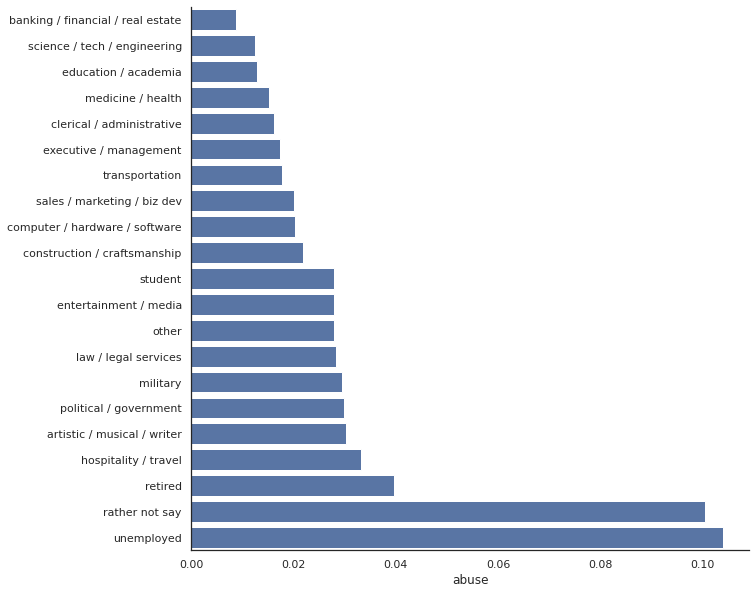

In [90]:
sns.set_style("white")
plt.figure(figsize=(10,10))
sns.barplot(x="abuse", y=job_relative.index, data=job_relative, orient="h", color="b")
plt.ylabel("")
sns.despine()
plt.show()

### Does having kids decrease the likelihood of substance abuse?

In [91]:
kids = df_dummy.dropna(axis=0, subset=["offspring"]).groupby("offspring")["abuse"].mean().to_frame()

In [92]:
kids.rename_axis("has kids")

,abuse
has kids,
0.0,0.027325
1.0,0.014981


### Does owning a pet help?

In [93]:
pets = df_dummy.groupby("has_pets")["abuse"].mean().to_frame()
pets

,abuse
has_pets,
False,0.021856
True,0.028102


### Substance abuse among religion

In [94]:
religion = df_dummy.groupby("religion")["abuse"].mean().sort_values().to_frame()
religion

,abuse
religion,
judaism,0.010686
christianity,0.012597
catholicism,0.018006
agnosticism,0.021765
buddhism,0.024135
other,0.028526
hinduism,0.032154
atheism,0.034012
islam,0.111111


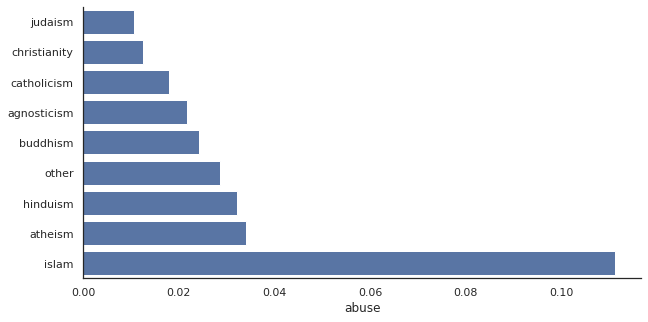

In [95]:
plt.figure(figsize=(10,5))
sns.barplot(x="abuse", y=religion.index, data=religion, orient="h", color="b")
plt.ylabel("")
sns.despine()
plt.show()

In [96]:
df_dummy.groupby("religion")["abuse"].sum().sort_values().to_frame()

,abuse
religion,
hinduism,10
islam,10
judaism,19
buddhism,30
christianity,44
catholicism,52
agnosticism,126
other,144
atheism,162


In [97]:
df_dummy["religion"].value_counts()

agnosticism     5789
other           5048
atheism         4763
christianity    3493
catholicism     2888
judaism         1778
buddhism        1243
hinduism         311
islam             90
Name: religion, dtype: int64

In [98]:
df_dummy["religious"]

0        1
1        0
5        0
7        0
8        0
        ..
59936    0
59937    0
59942    0
59943    0
59944    0
Name: religious, Length: 25403, dtype: int64